In [72]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from imblearn.over_sampling import SMOTE

%matplotlib inline
plt.style.use('ggplot')
sns.set_palette('Blues')

print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir(os.getcwd()))

Current working directory: c:\Users\khale\OneDrive\Desktop\dataset
Files in directory: ['.git', 'assignments.csv', 'assignment_submissions.csv', 'attendances.csv', 'courses.csv', 'enrollments.csv', 'final_model.pkl', 'grades.csv', 'logistic_model.pkl', 'merged_data.csv', 'predictions.csv', 'search_results_2_year1.csv', 'search_results_34_year4.csv', 'Student_Pass_Fail_Predict copy 2.ipynb', 'Student_Pass_Fail_Predict copy 3.ipynb', 'Student_Pass_Fail_Predict copy.ipynb', 'users.csv']


Loaded enrollments.csv: 34204 rows
Loaded grades.csv: 34204 rows
Loaded attendances.csv: 1043440 rows
Before merge: enrollments=34204, grades=34204
After enrollment-grades merge: 34204 rows
After enrolled_at conversion: 34204 rows
After dropping NaN enrolled_at: 34204 rows
Before attendance merge: 34204 rows
After attendance merge: 34204 rows
Unique final values before processing: [43. 40. 52. 46. 54. 45. 50. 41. 60. 53. 47. 58. 51. 44. 49. 57. 42. nan
 59. 56. 55. 48.]
Converted numeric final to pass/fail with threshold=60
After final column filter: 34204 rows
Saved merged data to merged_data.csv
Data shape: (34204, 6)
Target distribution:
 final
0    0.959595
1    0.040405
Name: proportion, dtype: float64
Missing values:
 quiz1                    0
quiz2                    0
midterm                  0
assignments              0
project                  0
attendance_percentage    0
dtype: int64
Feature ranges:
               quiz1         quiz2       midterm   assignments       projec

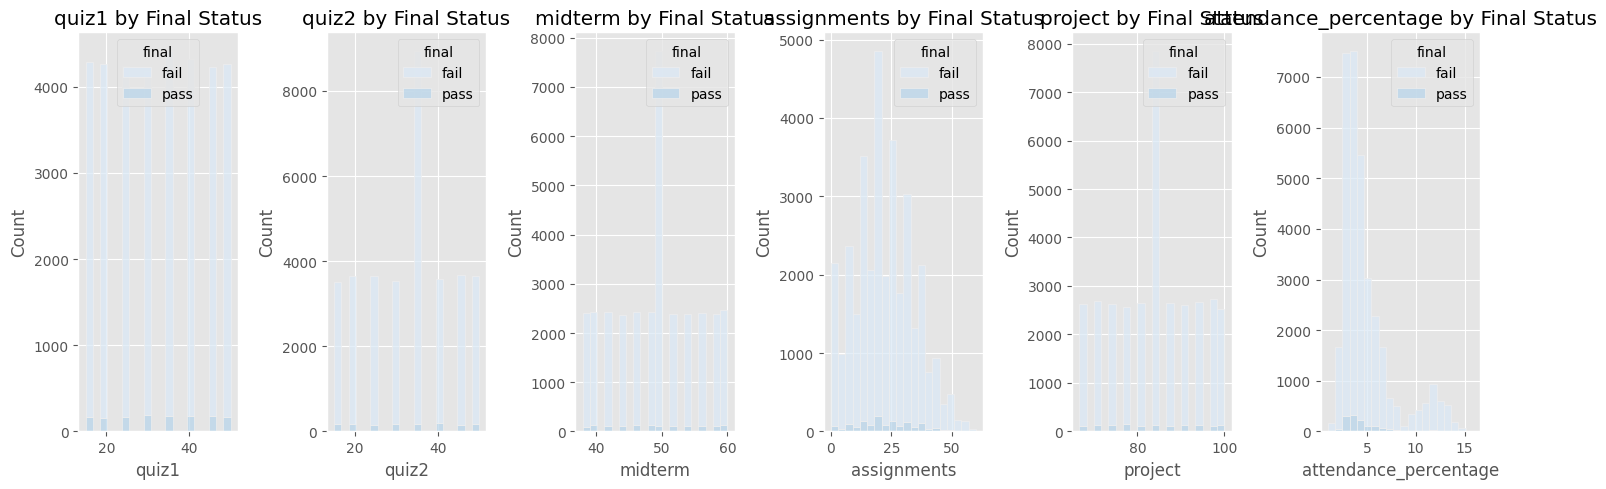

In [73]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load CSV files
def load_csv(file_name, default_dir=os.getcwd()):
    file_path = os.path.join(default_dir, file_name)
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found.")
        df = pd.read_csv(file_path)
        print(f"Loaded {file_name}: {df.shape[0]} rows")
        return df
    except FileNotFoundError as e:
        print(e)
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load data
enrollments = load_csv('enrollments.csv')
grades = load_csv('grades.csv')
attendances = load_csv('attendances.csv')

data = None
X = None
y = None
feature_names = ['quiz1', 'quiz2', 'midterm', 'assignments', 'project', 'attendance_percentage']

if enrollments is not None and grades is not None and attendances is not None:
    # Merge data
    print(f"Before merge: enrollments={len(enrollments)}, grades={len(grades)}")
    data = pd.merge(
        enrollments[['student_id', 'course_id', 'enrolled_at']],
        grades[['student_id', 'course_id', 'quiz1', 'quiz2', 'midterm', 'assignments', 'project', 'final']],
        on=['student_id', 'course_id'],
        how='inner'
    )
    print(f"After enrollment-grades merge: {len(data)} rows")

    # Convert enrolled_at to datetime
    data['enrolled_at'] = pd.to_datetime(data['enrolled_at'], errors='coerce')
    print(f"After enrolled_at conversion: {len(data)} rows")
    data = data.dropna(subset=['enrolled_at'])
    print(f"After dropping NaN enrolled_at: {len(data)} rows")

    # Scale scores to 0-100 (assuming max: quiz1=20, quiz2=20, midterm=50, assignments=50, project=30)
    data['quiz1'] = pd.to_numeric(data['quiz1'], errors='coerce') * (100 / 20)
    data['quiz2'] = pd.to_numeric(data['quiz2'], errors='coerce') * (100 / 20)
    data['midterm'] = pd.to_numeric(data['midterm'], errors='coerce') * (100 / 50)
    data['assignments'] = pd.to_numeric(data['assignments'], errors='coerce') * (100 / 50)
    data['project'] = pd.to_numeric(data['project'], errors='coerce') * (100 / 30)

    # Clean features
    for col in feature_names[:-1]:
        data[col] = data[col].clip(0, 100)
        data[col] = data[col].fillna(data[col].median())

    # Add attendance percentage
    total_sessions = attendances.groupby('course_id').apply(
        lambda x: x[['date', 'type']].drop_duplicates().shape[0],
        include_groups=False
    ).reset_index(name='total_sessions')
    present_count = attendances[attendances['status'] == 'present'].groupby(
        ['student_id', 'course_id']
    ).size().reset_index(name='present_count')
    print(f"Before attendance merge: {len(data)} rows")
    data = pd.merge(data, present_count, on=['student_id', 'course_id'], how='left')
    data = pd.merge(data, total_sessions, on='course_id', how='left')
    data['attendance_percentage'] = (data['present_count'] / data['total_sessions']) * 100
    data['attendance_percentage'] = data['attendance_percentage'].clip(0, 100).fillna(0)
    print(f"After attendance merge: {len(data)} rows")

    # Inspect and handle the final column
    print("Unique final values before processing:", data['final'].unique())
    data['final'] = data['final'].astype(str).str.lower()

    # Convert numeric final to pass/fail if applicable
    numeric_final = pd.to_numeric(data['final'], errors='coerce')
    if not numeric_final.isna().all():
        pass_threshold = 60  # Adjust this based on your grading scale (e.g., 50, 70)
        data['final'] = np.where(numeric_final >= pass_threshold, 'pass', 'fail')
        print(f"Converted numeric final to pass/fail with threshold={pass_threshold}")
    else:
        print("No numeric values detected in 'final' column.")

    # Filter to keep only 'pass' or 'fail'
    data = data[data['final'].isin(['pass', 'fail'])]
    print(f"After final column filter: {len(data)} rows")

    if data.empty:
        print("ERROR: Dataset is empty after filtering. Check 'final' column values in grades.csv.")
    else:
        # Save merged data
        data.to_csv('merged_data.csv', index=False)
        print("Saved merged data to merged_data.csv")

        # Prepare features and target
        X = data[feature_names]
        y = data['final'].map({'pass': 1, 'fail': 0})

        # Diagnostics
        print("Data shape:", X.shape)
        print("Target distribution:\n", y.value_counts(normalize=True))
        print("Missing values:\n", X.isnull().sum())
        print("Feature ranges:\n", X.describe())

        # Plot feature distributions
        plt.figure(figsize=(15, 5))
        for i, feature in enumerate(feature_names, 1):
            plt.subplot(1, len(feature_names), i)
            sns.histplot(data=data, x=feature, hue='final', multiple='stack', bins=20)
            plt.title(f'{feature} by Final Status')
        plt.tight_layout()
        plt.show()
else:
    print("Data loading failed. Please check CSV files.")

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Assuming 'data' is the DataFrame from Cell 2 (loaded from grades.csv)
# Define semesters based on created_at
semester_dates = {
    '2022-01-01': 1, '2022-08-01': 2,
    '2023-01-01': 3, '2023-08-01': 4,
    '2024-01-01': 5, '2024-08-01': 6,
    '2025-01-01': 7, '2025-08-01': 8
}
data['semester_num'] = pd.to_datetime(data['created_at']).dt.strftime('%Y-%m-%d').map(semester_dates)

# Filter rows with complete data
required_cols = ['quiz1', 'quiz2', 'midterm', 'assignments', 'project', 'status']
data = data.dropna(subset=required_cols + ['semester_num'])
print(f"After filtering complete records: {len(data)} rows")

# Feature engineering
feature_names = ['quiz1', 'quiz2', 'midterm', 'assignments', 'project']
data['midterm_assignments'] = data['midterm'] * data['assignments']
data['quiz_average'] = (data['quiz1'] + data['quiz2']) / 2
feature_names_extended = feature_names + ['midterm_assignments', 'quiz_average']

# Normalize features to 0–1
normalizer = MinMaxScaler()
data[feature_names_extended] = normalizer.fit_transform(data[feature_names_extended])

# Train/test split by semester
target_semesters = [7, 8]
train_semesters = list(range(1, target_semesters[0]))
train_data = data[data['semester_num'].isin(train_semesters)].copy()
test_data = data[data['semester_num'].isin(target_semesters)].copy()
print(f"Train data: {len(train_data)} rows, Test data: {len(test_data)} rows")

if not train_data.empty and not test_data.empty:
    X_train = train_data[feature_names_extended]
    y_train = train_data['status'].map({'pass': 1, 'fail': 0})
    X_test = test_data[feature_names_extended]
    y_test = test_data['status'].map({'pass': 1, 'fail': 0})

    # Scale features with RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Balance training data with undersampling + SMOTE
    sampling_pipeline = Pipeline([
        ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
        ('smote', SMOTE(sampling_strategy=1.0, random_state=42))
    ])
    X_train_balanced, y_train_balanced = sampling_pipeline.fit_resample(X_train_scaled, y_train)
    print("Balanced training set:", pd.Series(y_train_balanced).value_counts(normalize=True))

    # Logistic Regression
    lr_model = LogisticRegression(
        C=1, solver='liblinear', class_weight={0:1, 1:20}, max_iter=5000, random_state=42
    )
    lr_model.fit(X_train_balanced, y_train_balanced)

    # Gradient Boosting
    gb_model = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    )
    gb_model.fit(X_train_balanced, y_train_balanced)

    # Evaluate models
    models = [("Logistic Regression", lr_model), ("Gradient Boosting", gb_model)]
    for name, model in models:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        y_pred = (y_prob >= optimal_threshold).astype(int)

        print(f"\n{name} Results (threshold={optimal_threshold:.2f}):")
        print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Fail', 'Pass'], zero_division=0))

    # Check student ID 123
    student_123 = test_data[test_data['student_id'] == 123]
    if not student_123.empty:
        X_123 = student_123[feature_names_extended]
        X_123_scaled = scaler.transform(X_123)
        lr_prob = lr_model.predict_proba(X_123_scaled)[:, 1][0]
        gb_prob = gb_model.predict_proba(X_123_scaled)[:, 1][0]
        print(f"\nStudent ID 123 (Course {student_123['course_id'].iloc[0]}):")
        print(f"Logistic Regression 'Pass' Probability: {lr_prob:.2f}")
        print(f"Gradient Boosting 'Pass' Probability: {gb_prob:.2f}")
else:
    print("Insufficient data for selected semesters.")

KeyError: 'created_at'

In [ ]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(
        cm, text_auto=True, color_continuous_scale='Blues',
        x=['Fail', 'Pass'], y=['Fail', 'Pass'],
        labels={'x': 'Predicted', 'y': 'Actual'},
        title=f'Confusion Matrix (Threshold={threshold})'
    )
    fig.update_layout(width=600, height=600)
    fig.show()

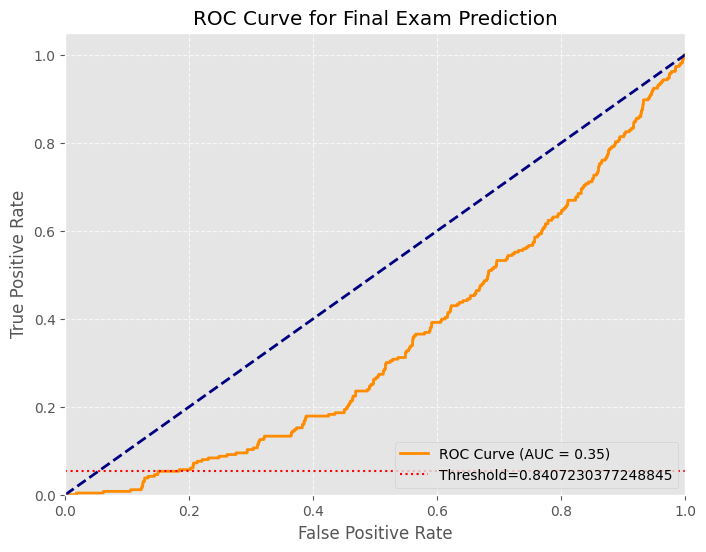

In [ ]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axhline(y=tpr[np.argmin(np.abs(fpr - (1 - threshold)))], color='red', linestyle=':', label=f'Threshold={threshold}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Final Exam Prediction')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    if isinstance(model, RandomForestClassifier):
        coef_df = pd.DataFrame({
            'Feature': feature_names + ['midterm_assignments'],
            'Importance': model.feature_importances_
        })
        title = 'Feature Importance (Random Forest)'
        y_label = 'Importance'
    else:
        coef_df = pd.DataFrame({
            'Feature': feature_names + ['midterm_assignments'],
            'Coefficient': model.coef_[0]
        })
        title = 'Feature Importance (Logistic Regression)'
        y_label = 'Coefficient'
    fig = px.bar(coef_df, x='Feature', y=coef_df.columns[1], color=coef_df.columns[1],
                 color_continuous_scale='RdBu', height=500, title=title)
    fig.update_layout(xaxis_title='Feature', yaxis_title=y_label,
                     showlegend=False, template='plotly_white')
    fig.show()

In [ ]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    import joblib
    joblib.dump(model, 'final_model.pkl')
    print("Model saved as final_model.pkl")
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).to_csv('predictions.csv')
    print("Predictions saved as predictions.csv")

Model saved as final_model.pkl
Predictions saved as predictions.csv


In [ ]:
if enrollments is not None and grades is not None and attendances is not None and model is not None and data is not None and scaler is not None:
    def search_student(student_id, year=4):
        target_semesters = [7, 8] if year == 4 else [2*year-1, 2*year]
        student_data = data[(data['student_id'] == student_id) & (data['semester_num'].isin(target_semesters))]
        
        if student_data.empty:
            print(f"No data for student ID {student_id} in Year {year} semesters.")
            print("Valid student IDs:", data['student_id'].unique()[:10], "...")
            return
        
        print(f"\nStudent ID: {student_id} (Year {year}, Semesters {target_semesters})")
        for _, row in student_data.iterrows():
            print(f"Course ID: {row['course_id']}, Semester: {row['enrolled_at'].date()}")
            for feature in feature_names:
                print(f"  {feature.capitalize()}: {row[feature]:.2f}")
            print(f"  Actual Final Status: {row['final']}")
            features = pd.DataFrame([row[feature_names]], columns=feature_names)
            features_scaled = scaler.transform(features)
            prob = model.predict_proba(features_scaled)[0][1]
            prediction = 1 if prob >= threshold else 0
            print(f"  Predicted Final Status: {'Pass' if prediction == 1 else 'Fail'} (Probability of Pass: {prob:.2%})")
            if prediction != (1 if row['final'] == 'pass' else 0):
                print("  WARNING: Prediction does not match actual status!")
        
        search_results = student_data[['student_id', 'course_id', 'enrolled_at'] + feature_names + ['final']].copy()
        search_results['predicted_status'] = ['Pass' if p >= threshold else 'Fail' for p in model.predict_proba(scaler.transform(student_data[feature_names]))[:, 1]]
        search_results['pass_probability'] = model.predict_proba(scaler.transform(student_data[feature_names]))[:, 1]
        search_results.to_csv(f'search_results_{student_id}_year{year}.csv', index=False)
        print(f"Search results saved to search_results_{student_id}_year{year}.csv")
        print(f"\nNote: Predictions use threshold={threshold}")

    student_id_input = widgets.IntText(value=1, description='Student ID:')
    year_input = widgets.Dropdown(options=[1, 2, 3, 4], value=4, description='Year:')
    button = widgets.Button(description="Search")
    
    def on_button_clicked(b):
        search_student(student_id_input.value, year_input.value)
    
    button.on_click(on_button_clicked)
    display(student_id_input, year_input, button)

    batch_input = widgets.Text(value='1,2,3', description='Student IDs (comma-separated):')
    batch_year_input = widgets.Dropdown(options=[1, 2, 3, 4], value=4, description='Year:')
    batch_button = widgets.Button(description="Batch Search")
    
    def on_batch_clicked(b):
        ids = [int(id.strip()) for id in batch_input.value.split(',') if id.strip().isdigit()]
        for student_id in ids:
            search_student(student_id, batch_year_input.value)
    
    batch_button.on_click(on_batch_clicked)
    display(batch_input, batch_year_input, batch_button)
else:
    print("Cannot perform search due to data or model issues.")

IntText(value=1, description='Student ID:')

Dropdown(description='Year:', index=3, options=(1, 2, 3, 4), value=4)

Button(description='Search', style=ButtonStyle())

Text(value='1,2,3', description='Student IDs (comma-separated):')

Dropdown(description='Year:', index=3, options=(1, 2, 3, 4), value=4)

Button(description='Batch Search', style=ButtonStyle())

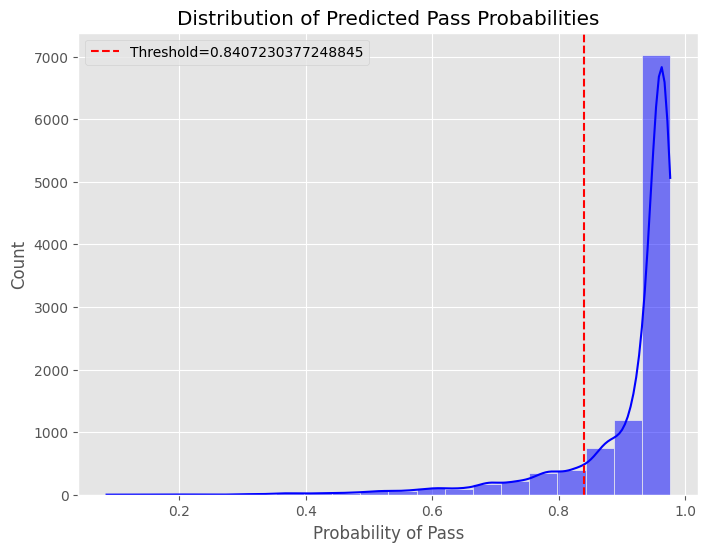

In [ ]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    plt.figure(figsize=(8, 6))
    sns.histplot(y_prob, bins=20, kde=True, color='blue')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
    plt.title('Distribution of Predicted Pass Probabilities')
    plt.xlabel('Probability of Pass')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [ ]:
if data is not None and 'student_id' in data.columns:
    # Get unique student IDs
    unique_student_ids = data['student_id'].unique()
    total_ids = len(unique_student_ids)
    
    # Display first 10 IDs (or all if fewer than 10)
    display_ids = unique_student_ids[:16]
    print(f"Total unique student IDs available for search: {total_ids}")
    print("Example student IDs (first 16):")
    for sid in display_ids:
        print(sid)
    if total_ids > 16:
        print("... (use Cell 8 to search for any ID in the dataset)")
else:
    print("Cannot display student IDs: Data is not loaded or student_id column is missing.")

Total unique student IDs available for search: 1002
Example student IDs (first 16):
2
3
29
30
31
32
33
34
35
36
37
38
39
40
41
42
... (use Cell 8 to search for any ID in the dataset)
